In [1]:
import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 

In [2]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results







In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [20]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [21]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [22]:
configs.specifier = specifier
configs.data_name = data_name



In [23]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

# demo-Fcls-mm:

- Chosen model: **MLP**



https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

## Load Data

In [8]:

dd = DyslexiaData(path="../../datasets/", n_repeats=5)




In [9]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 


In [10]:

df_data_to_use.head()



,Group,SubjectID,Sex,Grade,Age,IQ,Reading_speed
0,1,10,1,4,10,23,102.0
1,1,108,1,4,10,34,139.0
2,1,11,2,4,10,34,110.0
3,1,11_norm1,1,2,9,28,71.0
4,1,12_norm1,2,2,8,32,60.0


In [11]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [12]:

x_org.head()



,Grade_3,Sex_2,Grade_5,IQ,Grade_4,Age,Sex_1,Grade_6,Grade_1,Grade_2
0,0,0,0,23,1,10,1,0,0,0
1,0,0,0,34,1,10,1,0,0,0
2,0,1,0,34,1,10,0,0,0,0
3,0,0,0,28,0,9,1,0,0,1
4,0,1,0,32,0,8,0,0,0,1


In [13]:
# for i in range(x_org.Sex_1.values.shape[0]):
#     print(x_org.Sex_1.values[i], x_org.Sex_2.values[i])

In [14]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,139.0
2,1,110.0
3,1,71.0
4,1,60.0


In [15]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [16]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (307, 10)


In [17]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [18]:

data



defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0., 0., 0., ..., 0., 0., 0.],
                                 [0., 0., 0., ..., 0., 0., 0.],
                                 [0., 1., 0., ..., 0., 0., 1.],
                                 ...,
                                 [0., 1., 0., ..., 0., 1., 0.],
                                 [1., 0., 0., ..., 0., 0., 0.],
                                 [1., 1., 0., ..., 0., 0., 0.]]),
                          'x_test': array([[0.   , 1.   , 0.   , 0.905, 1.   , 0.5  , 0.   , 0.   , 0.   ,
                                  0.   ],
                                 [0.   , 0.   , 0.   , 0.619, 0.   , 0.375, 1.   , 0.   , 0.   ,
                                  1.   ],
                                 [0.   , 1.   , 0.   , 0.571, 1.   , 0.5  , 0.   , 0.   , 0.   ,
                                  0.   ],
                                 [0.   , 0.   , 0.   , 0.667, 0. 

## Load the tuned parameters

In [25]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [26]:
# OrderedDict([('activation', 'identity'),
#              ('hidden_layer_sizes', 173),
#              ('max_iter', 31270),
#              ('solver', 'lbfgs')])



In [27]:
specifier

'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

In [28]:
# save_a_dict(a_dict=tuned_params,
#             name='dd_fix_demo-mlp_reg--shuffled:True--exclude at risk:0',
#             save_path=configs.params_path,
#            )

In [29]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
    
)

mdl


MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [44]:
x_train = data["6"]["x_train"]
x_test = data["6"]["x_test"]
y_train = data["6"]["y_train"]
y_test = data["6"]["y_test"]



In [45]:

class_names = ['Norm', 'At-risk', 'Dyslexic']




In [46]:
# from joblib import dump, load


# mdl = load(configs.models_path.joinpath(configs.specifier+".joblib"))
# mdl


In [47]:

# results = load_a_dict(
#     name=configs.specifier,
#     save_path=configs.results_path,
#         )




# for i in range(1, 11):
#     i = str(i)
#     y_test_ = results[i]["y_test"]
#     y_pred_ = results[i]["y_pred"]
#     y_prob_ = results[i]["y_pred_prob"]
    
#     cm = sklearn.metrics.confusion_matrix(
#     y_true=y_test_, 
#     y_pred=y_pred_
#     )
    
#     disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=class_names
#                              )
#     disp.plot()
#     plt.show()
    
    
#     print(
#         "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
#         "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
#                                                   multi_class="ovr",
#                                                   average="weighted")
#     )





In [48]:


# print_the_evaluated_results(
#     results=results, 
#     learning_method=learning_method
# )



In [49]:
y_train.shape, x_test.shape

((276,), (31, 10))

In [50]:


mdl.fit(x_train, y_train)




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2215     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65187D-01    |proj g|=  2.81610D-01

At iterate    1    f=  7.72619D-01    |proj g|=  6.07444D-02

At iterate    2    f=  7.54515D-01    |proj g|=  2.67068D-02

At iterate    3    f=  7.37511D-01    |proj g|=  1.94083D-02

At iterate    4    f=  7.29511D-01    |proj g|=  1.84961D-02

At iterate    5    f=  7.15984D-01    |proj g|=  1.30115D-02

At iterate    6    f=  7.09393D-01    |proj g|=  4.68669D-03

At iterate    7    f=  7.04882D-01    |proj g|=  3.90006D-03

At iterate    8    f=  7.01644D-01    |proj g|=  6.25210D-03

At iterate    9    f=  6.98876D-01    |proj g|=  4.71655D-03

At iterate   10    f=  6.98098D-01    |proj g|=  5.01245D-03

At iterate   11    f=  6.97812D-01    |proj g|=  1.23052D-03

At iterate   12    f=  6.97645D-01    |proj g|=  2.04229D-03

At iterate   13    f=  6.9

 This problem is unconstrained.



At iterate   66    f=  6.59673D-01    |proj g|=  2.70528D-03

At iterate   67    f=  6.59507D-01    |proj g|=  2.36116D-03

At iterate   68    f=  6.59026D-01    |proj g|=  2.76145D-03

At iterate   69    f=  6.58434D-01    |proj g|=  4.70137D-03

At iterate   70    f=  6.57531D-01    |proj g|=  4.68520D-03

At iterate   71    f=  6.56667D-01    |proj g|=  7.58700D-03

At iterate   72    f=  6.56131D-01    |proj g|=  7.59786D-03

At iterate   73    f=  6.55366D-01    |proj g|=  4.90752D-03

At iterate   74    f=  6.54794D-01    |proj g|=  6.15460D-03

At iterate   75    f=  6.54380D-01    |proj g|=  7.09559D-03

At iterate   76    f=  6.53993D-01    |proj g|=  5.10600D-03

At iterate   77    f=  6.53835D-01    |proj g|=  3.57859D-03

At iterate   78    f=  6.53751D-01    |proj g|=  3.38596D-03

At iterate   79    f=  6.53403D-01    |proj g|=  3.59945D-03

At iterate   80    f=  6.52810D-01    |proj g|=  4.62106D-03

At iterate   81    f=  6.52035D-01    |proj g|=  6.49558D-03

At iter


At iterate  239    f=  5.74491D-01    |proj g|=  7.31234D-03

At iterate  240    f=  5.74193D-01    |proj g|=  7.91951D-03

At iterate  241    f=  5.73761D-01    |proj g|=  9.07405D-03

At iterate  242    f=  5.73279D-01    |proj g|=  7.05130D-03

At iterate  243    f=  5.72431D-01    |proj g|=  8.90860D-03

At iterate  244    f=  5.71932D-01    |proj g|=  9.43729D-03

At iterate  245    f=  5.71386D-01    |proj g|=  1.34649D-02

At iterate  246    f=  5.71087D-01    |proj g|=  9.26700D-03

At iterate  247    f=  5.70920D-01    |proj g|=  5.17251D-03

At iterate  248    f=  5.70771D-01    |proj g|=  4.44496D-03

At iterate  249    f=  5.70425D-01    |proj g|=  6.34420D-03

At iterate  250    f=  5.69992D-01    |proj g|=  5.43918D-03

At iterate  251    f=  5.69889D-01    |proj g|=  1.41328D-02

At iterate  252    f=  5.69562D-01    |proj g|=  7.83540D-03

At iterate  253    f=  5.69280D-01    |proj g|=  9.02969D-03

At iterate  254    f=  5.68842D-01    |proj g|=  8.03849D-03

At iter


At iterate  372    f=  5.33832D-01    |proj g|=  3.92063D-03

At iterate  373    f=  5.33712D-01    |proj g|=  3.01662D-03

At iterate  374    f=  5.33340D-01    |proj g|=  3.86242D-03

At iterate  375    f=  5.33179D-01    |proj g|=  6.79659D-03

At iterate  376    f=  5.32940D-01    |proj g|=  6.36358D-03

At iterate  377    f=  5.32730D-01    |proj g|=  6.49371D-03

At iterate  378    f=  5.32513D-01    |proj g|=  5.48148D-03

At iterate  379    f=  5.32138D-01    |proj g|=  4.42845D-03

At iterate  380    f=  5.31768D-01    |proj g|=  1.09205D-02

At iterate  381    f=  5.31517D-01    |proj g|=  1.43514D-02

At iterate  382    f=  5.31215D-01    |proj g|=  8.26367D-03

At iterate  383    f=  5.30958D-01    |proj g|=  7.14680D-03

At iterate  384    f=  5.30710D-01    |proj g|=  7.24133D-03

At iterate  385    f=  5.30031D-01    |proj g|=  1.10554D-02

At iterate  386    f=  5.29480D-01    |proj g|=  1.41436D-02

At iterate  387    f=  5.28877D-01    |proj g|=  1.78326D-02

At iter


At iterate  547    f=  4.86064D-01    |proj g|=  4.68100D-03

At iterate  548    f=  4.85948D-01    |proj g|=  4.26627D-03

At iterate  549    f=  4.85656D-01    |proj g|=  8.18476D-03

At iterate  550    f=  4.85310D-01    |proj g|=  5.80351D-03

At iterate  551    f=  4.85012D-01    |proj g|=  5.43867D-03

At iterate  552    f=  4.84666D-01    |proj g|=  6.51762D-03

At iterate  553    f=  4.84351D-01    |proj g|=  5.72521D-03

At iterate  554    f=  4.84042D-01    |proj g|=  1.16065D-02

At iterate  555    f=  4.83729D-01    |proj g|=  7.03876D-03

At iterate  556    f=  4.83392D-01    |proj g|=  6.30395D-03

At iterate  557    f=  4.82983D-01    |proj g|=  1.52180D-02

At iterate  558    f=  4.82583D-01    |proj g|=  1.29433D-02

At iterate  559    f=  4.82251D-01    |proj g|=  8.85923D-03

At iterate  560    f=  4.82026D-01    |proj g|=  6.97409D-03

At iterate  561    f=  4.81559D-01    |proj g|=  5.01108D-03

At iterate  562    f=  4.81024D-01    |proj g|=  9.08718D-03

At iter


At iterate  697    f=  4.16937D-01    |proj g|=  5.24832D-03

At iterate  698    f=  4.16793D-01    |proj g|=  1.41551D-02

At iterate  699    f=  4.16530D-01    |proj g|=  8.65050D-03

At iterate  700    f=  4.16220D-01    |proj g|=  7.27134D-03

At iterate  701    f=  4.15978D-01    |proj g|=  7.94445D-03

At iterate  702    f=  4.15804D-01    |proj g|=  1.52084D-02

At iterate  703    f=  4.15454D-01    |proj g|=  1.03833D-02

At iterate  704    f=  4.15059D-01    |proj g|=  1.36937D-02

At iterate  705    f=  4.14416D-01    |proj g|=  1.45899D-02

At iterate  706    f=  4.13454D-01    |proj g|=  1.04564D-02

At iterate  707    f=  4.12556D-01    |proj g|=  3.09386D-02

At iterate  708    f=  4.10822D-01    |proj g|=  1.13116D-02

At iterate  709    f=  4.09872D-01    |proj g|=  9.87879D-03

At iterate  710    f=  4.09543D-01    |proj g|=  2.61099D-02

At iterate  711    f=  4.09014D-01    |proj g|=  1.18731D-02

At iterate  712    f=  4.08701D-01    |proj g|=  9.19704D-03

At iter


At iterate  830    f=  3.45100D-01    |proj g|=  1.44156D-02

At iterate  831    f=  3.44580D-01    |proj g|=  1.03273D-02

At iterate  832    f=  3.44195D-01    |proj g|=  1.01626D-02

At iterate  833    f=  3.43766D-01    |proj g|=  7.78440D-03

At iterate  834    f=  3.43214D-01    |proj g|=  1.22981D-02

At iterate  835    f=  3.42930D-01    |proj g|=  2.16701D-02

At iterate  836    f=  3.42525D-01    |proj g|=  6.44175D-03

At iterate  837    f=  3.42308D-01    |proj g|=  4.89016D-03

At iterate  838    f=  3.41975D-01    |proj g|=  8.13343D-03

At iterate  839    f=  3.41482D-01    |proj g|=  8.65715D-03

At iterate  840    f=  3.41144D-01    |proj g|=  1.33878D-02

At iterate  841    f=  3.40865D-01    |proj g|=  9.94825D-03

At iterate  842    f=  3.40649D-01    |proj g|=  6.19032D-03

At iterate  843    f=  3.40369D-01    |proj g|=  8.51875D-03

At iterate  844    f=  3.39954D-01    |proj g|=  8.89874D-03

At iterate  845    f=  3.39485D-01    |proj g|=  7.40253D-03

At iter


At iterate 1019    f=  3.05123D-01    |proj g|=  9.45603D-03

At iterate 1020    f=  3.05014D-01    |proj g|=  1.85154D-02

At iterate 1021    f=  3.04863D-01    |proj g|=  7.09002D-03

At iterate 1022    f=  3.04777D-01    |proj g|=  5.64959D-03

At iterate 1023    f=  3.04638D-01    |proj g|=  1.05193D-02

At iterate 1024    f=  3.04513D-01    |proj g|=  1.06894D-02

At iterate 1025    f=  3.04388D-01    |proj g|=  9.77788D-03

At iterate 1026    f=  3.04267D-01    |proj g|=  4.05611D-03

At iterate 1027    f=  3.04198D-01    |proj g|=  3.12971D-03

At iterate 1028    f=  3.04091D-01    |proj g|=  5.23499D-03

At iterate 1029    f=  3.04022D-01    |proj g|=  1.39944D-02

At iterate 1030    f=  3.03926D-01    |proj g|=  8.71665D-03

At iterate 1031    f=  3.03863D-01    |proj g|=  3.41158D-03

At iterate 1032    f=  3.03812D-01    |proj g|=  4.75582D-03

At iterate 1033    f=  3.03806D-01    |proj g|=  1.87652D-02

At iterate 1034    f=  3.03748D-01    |proj g|=  9.07291D-03

At iter


At iterate 1191    f=  2.97099D-01    |proj g|=  1.79670D-03

At iterate 1192    f=  2.97087D-01    |proj g|=  2.39881D-03

At iterate 1193    f=  2.97069D-01    |proj g|=  2.41535D-03

At iterate 1194    f=  2.97034D-01    |proj g|=  5.45683D-03

At iterate 1195    f=  2.97018D-01    |proj g|=  7.52230D-03

At iterate 1196    f=  2.96969D-01    |proj g|=  4.17661D-03

At iterate 1197    f=  2.96948D-01    |proj g|=  4.23520D-03

At iterate 1198    f=  2.96933D-01    |proj g|=  2.56893D-03

At iterate 1199    f=  2.96902D-01    |proj g|=  1.97875D-03

At iterate 1200    f=  2.96857D-01    |proj g|=  3.03037D-03

At iterate 1201    f=  2.96837D-01    |proj g|=  6.19733D-03

At iterate 1202    f=  2.96802D-01    |proj g|=  3.01207D-03

At iterate 1203    f=  2.96779D-01    |proj g|=  1.85093D-03

At iterate 1204    f=  2.96747D-01    |proj g|=  3.52731D-03

At iterate 1205    f=  2.96696D-01    |proj g|=  6.14733D-03

At iterate 1206    f=  2.96626D-01    |proj g|=  2.78682D-03

At iter


At iterate 1373    f=  2.87864D-01    |proj g|=  7.36578D-03

At iterate 1374    f=  2.87836D-01    |proj g|=  2.65896D-03

At iterate 1375    f=  2.87813D-01    |proj g|=  2.53279D-03

At iterate 1376    f=  2.87791D-01    |proj g|=  5.57231D-03

At iterate 1377    f=  2.87746D-01    |proj g|=  4.50535D-03

At iterate 1378    f=  2.87714D-01    |proj g|=  1.11675D-02

At iterate 1379    f=  2.87667D-01    |proj g|=  5.85686D-03

At iterate 1380    f=  2.87621D-01    |proj g|=  3.07959D-03

At iterate 1381    f=  2.87598D-01    |proj g|=  4.18999D-03

At iterate 1382    f=  2.87529D-01    |proj g|=  6.78512D-03

At iterate 1383    f=  2.87475D-01    |proj g|=  6.89642D-03

At iterate 1384    f=  2.87427D-01    |proj g|=  2.66821D-03

At iterate 1385    f=  2.87404D-01    |proj g|=  3.04956D-03

At iterate 1386    f=  2.87379D-01    |proj g|=  4.54902D-03

At iterate 1387    f=  2.87354D-01    |proj g|=  4.98085D-03

At iterate 1388    f=  2.87306D-01    |proj g|=  3.21310D-03

At iter


At iterate 1551    f=  2.77040D-01    |proj g|=  4.01903D-03

At iterate 1552    f=  2.76988D-01    |proj g|=  3.05678D-03

At iterate 1553    f=  2.76913D-01    |proj g|=  5.12979D-03

At iterate 1554    f=  2.76874D-01    |proj g|=  9.60178D-03

At iterate 1555    f=  2.76829D-01    |proj g|=  5.75599D-03

At iterate 1556    f=  2.76766D-01    |proj g|=  2.96694D-03

At iterate 1557    f=  2.76732D-01    |proj g|=  3.99236D-03

At iterate 1558    f=  2.76674D-01    |proj g|=  3.51251D-03

At iterate 1559    f=  2.76660D-01    |proj g|=  3.88887D-03

At iterate 1560    f=  2.76633D-01    |proj g|=  2.07394D-03

At iterate 1561    f=  2.76605D-01    |proj g|=  1.92273D-03

At iterate 1562    f=  2.76546D-01    |proj g|=  8.45126D-03

At iterate 1563    f=  2.76497D-01    |proj g|=  4.63583D-03

At iterate 1564    f=  2.76457D-01    |proj g|=  3.11203D-03

At iterate 1565    f=  2.76389D-01    |proj g|=  3.36925D-03

At iterate 1566    f=  2.76354D-01    |proj g|=  7.50767D-03

At iter


At iterate 1726    f=  2.68672D-01    |proj g|=  2.45776D-03

At iterate 1727    f=  2.68660D-01    |proj g|=  1.72799D-03

At iterate 1728    f=  2.68645D-01    |proj g|=  3.28432D-03

At iterate 1729    f=  2.68622D-01    |proj g|=  3.58194D-03

At iterate 1730    f=  2.68610D-01    |proj g|=  1.49226D-02

At iterate 1731    f=  2.68540D-01    |proj g|=  3.41806D-03

At iterate 1732    f=  2.68507D-01    |proj g|=  3.08484D-03

At iterate 1733    f=  2.68471D-01    |proj g|=  4.42936D-03

At iterate 1734    f=  2.68418D-01    |proj g|=  3.92149D-03

At iterate 1735    f=  2.68385D-01    |proj g|=  1.22623D-02

At iterate 1736    f=  2.68321D-01    |proj g|=  2.76978D-03

At iterate 1737    f=  2.68298D-01    |proj g|=  2.56305D-03

At iterate 1738    f=  2.68275D-01    |proj g|=  3.48761D-03

At iterate 1739    f=  2.68269D-01    |proj g|=  8.58879D-03

At iterate 1740    f=  2.68243D-01    |proj g|=  3.54156D-03

At iterate 1741    f=  2.68230D-01    |proj g|=  1.62587D-03

At iter


At iterate 1888    f=  2.64935D-01    |proj g|=  1.69030D-03

At iterate 1889    f=  2.64927D-01    |proj g|=  2.83763D-03

At iterate 1890    f=  2.64917D-01    |proj g|=  1.82972D-03

At iterate 1891    f=  2.64913D-01    |proj g|=  2.18648D-03

At iterate 1892    f=  2.64908D-01    |proj g|=  1.34910D-03

At iterate 1893    f=  2.64903D-01    |proj g|=  1.46807D-03

At iterate 1894    f=  2.64897D-01    |proj g|=  1.91035D-03

At iterate 1895    f=  2.64893D-01    |proj g|=  6.29751D-03

At iterate 1896    f=  2.64885D-01    |proj g|=  1.88366D-03

At iterate 1897    f=  2.64879D-01    |proj g|=  2.00442D-03

At iterate 1898    f=  2.64875D-01    |proj g|=  2.50336D-03

At iterate 1899    f=  2.64872D-01    |proj g|=  5.33848D-03

At iterate 1900    f=  2.64864D-01    |proj g|=  1.82350D-03

At iterate 1901    f=  2.64860D-01    |proj g|=  1.13982D-03

At iterate 1902    f=  2.64855D-01    |proj g|=  2.82835D-03

At iterate 1903    f=  2.64849D-01    |proj g|=  3.82002D-03

At iter


At iterate 2044    f=  2.63899D-01    |proj g|=  2.18282D-03

At iterate 2045    f=  2.63889D-01    |proj g|=  2.29801D-03

At iterate 2046    f=  2.63879D-01    |proj g|=  1.89348D-03

At iterate 2047    f=  2.63870D-01    |proj g|=  5.33115D-03

At iterate 2048    f=  2.63859D-01    |proj g|=  2.86369D-03

At iterate 2049    f=  2.63848D-01    |proj g|=  2.45512D-03

At iterate 2050    f=  2.63838D-01    |proj g|=  1.46952D-03

At iterate 2051    f=  2.63827D-01    |proj g|=  1.42017D-03

At iterate 2052    f=  2.63809D-01    |proj g|=  2.52916D-03

At iterate 2053    f=  2.63794D-01    |proj g|=  3.09556D-03

At iterate 2054    f=  2.63781D-01    |proj g|=  2.34848D-03

At iterate 2055    f=  2.63764D-01    |proj g|=  3.57081D-03

At iterate 2056    f=  2.63755D-01    |proj g|=  4.72417D-03

At iterate 2057    f=  2.63745D-01    |proj g|=  2.92169D-03

At iterate 2058    f=  2.63730D-01    |proj g|=  2.40113D-03

At iterate 2059    f=  2.63721D-01    |proj g|=  2.60348D-03

At iter


At iterate 2212    f=  2.62422D-01    |proj g|=  7.38536D-03

At iterate 2213    f=  2.62403D-01    |proj g|=  2.25011D-03

At iterate 2214    f=  2.62393D-01    |proj g|=  2.32931D-03

At iterate 2215    f=  2.62381D-01    |proj g|=  2.26174D-03

At iterate 2216    f=  2.62369D-01    |proj g|=  6.21739D-03

At iterate 2217    f=  2.62354D-01    |proj g|=  1.96236D-03

At iterate 2218    f=  2.62346D-01    |proj g|=  1.59495D-03

At iterate 2219    f=  2.62335D-01    |proj g|=  2.26764D-03

At iterate 2220    f=  2.62326D-01    |proj g|=  3.79169D-03

At iterate 2221    f=  2.62318D-01    |proj g|=  2.34937D-03

At iterate 2222    f=  2.62314D-01    |proj g|=  8.92844D-04

At iterate 2223    f=  2.62310D-01    |proj g|=  1.04576D-03

At iterate 2224    f=  2.62306D-01    |proj g|=  1.11476D-03

At iterate 2225    f=  2.62299D-01    |proj g|=  5.15118D-03

At iterate 2226    f=  2.62291D-01    |proj g|=  1.23026D-03

At iterate 2227    f=  2.62286D-01    |proj g|=  9.29260D-04

At iter


At iterate 2362    f=  2.61316D-01    |proj g|=  1.21049D-03

At iterate 2363    f=  2.61310D-01    |proj g|=  2.01674D-03

At iterate 2364    f=  2.61307D-01    |proj g|=  6.09739D-03

At iterate 2365    f=  2.61298D-01    |proj g|=  3.57733D-03

At iterate 2366    f=  2.61294D-01    |proj g|=  1.38666D-03

At iterate 2367    f=  2.61290D-01    |proj g|=  1.24229D-03

At iterate 2368    f=  2.61285D-01    |proj g|=  1.29753D-03

At iterate 2369    f=  2.61282D-01    |proj g|=  3.28322D-03

At iterate 2370    f=  2.61274D-01    |proj g|=  1.77149D-03

At iterate 2371    f=  2.61268D-01    |proj g|=  2.40236D-03

At iterate 2372    f=  2.61264D-01    |proj g|=  1.27552D-03

At iterate 2373    f=  2.61260D-01    |proj g|=  1.62329D-03

At iterate 2374    f=  2.61251D-01    |proj g|=  2.20840D-03

At iterate 2375    f=  2.61246D-01    |proj g|=  7.23768D-04

At iterate 2376    f=  2.61242D-01    |proj g|=  1.18118D-03

At iterate 2377    f=  2.61237D-01    |proj g|=  1.19134D-03

At iter

At iterate 2539    f=  2.60270D-01    |proj g|=  2.63833D-03

At iterate 2540    f=  2.60266D-01    |proj g|=  2.82615D-03

At iterate 2541    f=  2.60262D-01    |proj g|=  1.07218D-03

At iterate 2542    f=  2.60259D-01    |proj g|=  1.39879D-03

At iterate 2543    f=  2.60255D-01    |proj g|=  1.72234D-03

At iterate 2544    f=  2.60249D-01    |proj g|=  2.02925D-03

At iterate 2545    f=  2.60246D-01    |proj g|=  1.70020D-03

At iterate 2546    f=  2.60243D-01    |proj g|=  1.01364D-03

At iterate 2547    f=  2.60240D-01    |proj g|=  1.30590D-03

At iterate 2548    f=  2.60237D-01    |proj g|=  1.43059D-03

At iterate 2549    f=  2.60231D-01    |proj g|=  1.43067D-03

At iterate 2550    f=  2.60227D-01    |proj g|=  2.45476D-03

At iterate 2551    f=  2.60222D-01    |proj g|=  1.28149D-03

At iterate 2552    f=  2.60219D-01    |proj g|=  1.36802D-03

At iterate 2553    f=  2.60215D-01    |proj g|=  2.32202D-03

At iterate 2554    f=  2.60210D-01    |proj g|=  3.68831D-03

At itera


At iterate 2688    f=  2.59938D-01    |proj g|=  7.02743D-04

At iterate 2689    f=  2.59937D-01    |proj g|=  1.53835D-03

At iterate 2690    f=  2.59936D-01    |proj g|=  1.33964D-03

At iterate 2691    f=  2.59935D-01    |proj g|=  5.74483D-04

At iterate 2692    f=  2.59934D-01    |proj g|=  5.66580D-04

At iterate 2693    f=  2.59933D-01    |proj g|=  2.78820D-03

At iterate 2694    f=  2.59932D-01    |proj g|=  1.17663D-03

At iterate 2695    f=  2.59930D-01    |proj g|=  7.97615D-04

At iterate 2696    f=  2.59929D-01    |proj g|=  9.76657D-04

At iterate 2697    f=  2.59926D-01    |proj g|=  1.25079D-03

At iterate 2698    f=  2.59925D-01    |proj g|=  1.78799D-03

At iterate 2699    f=  2.59923D-01    |proj g|=  7.28501D-04

At iterate 2700    f=  2.59922D-01    |proj g|=  6.23273D-04

At iterate 2701    f=  2.59921D-01    |proj g|=  5.27173D-04

At iterate 2702    f=  2.59920D-01    |proj g|=  5.18957D-04

At iterate 2703    f=  2.59919D-01    |proj g|=  1.11917D-03

At iter


At iterate 2822    f=  2.59840D-01    |proj g|=  3.55425D-04

At iterate 2823    f=  2.59840D-01    |proj g|=  2.31248D-04

At iterate 2824    f=  2.59840D-01    |proj g|=  2.98021D-04

At iterate 2825    f=  2.59840D-01    |proj g|=  8.39607D-04

At iterate 2826    f=  2.59839D-01    |proj g|=  4.77900D-04

At iterate 2827    f=  2.59839D-01    |proj g|=  3.06609D-04

At iterate 2828    f=  2.59839D-01    |proj g|=  4.17822D-04

At iterate 2829    f=  2.59838D-01    |proj g|=  4.75971D-04

At iterate 2830    f=  2.59838D-01    |proj g|=  1.00181D-03

At iterate 2831    f=  2.59838D-01    |proj g|=  4.13704D-04

At iterate 2832    f=  2.59837D-01    |proj g|=  2.62396D-04

At iterate 2833    f=  2.59837D-01    |proj g|=  3.78930D-04

At iterate 2834    f=  2.59837D-01    |proj g|=  1.46675D-03

At iterate 2835    f=  2.59836D-01    |proj g|=  9.14783D-04

At iterate 2836    f=  2.59836D-01    |proj g|=  3.13019D-04

At iterate 2837    f=  2.59836D-01    |proj g|=  2.98453D-04

At iter


At iterate 2982    f=  2.59676D-01    |proj g|=  3.41373D-04

At iterate 2983    f=  2.59675D-01    |proj g|=  4.01112D-04

At iterate 2984    f=  2.59674D-01    |proj g|=  6.20308D-04

At iterate 2985    f=  2.59673D-01    |proj g|=  1.37672D-03

At iterate 2986    f=  2.59672D-01    |proj g|=  7.11919D-04

At iterate 2987    f=  2.59671D-01    |proj g|=  7.47116D-04

At iterate 2988    f=  2.59670D-01    |proj g|=  9.71796D-04

At iterate 2989    f=  2.59669D-01    |proj g|=  8.39416D-04

At iterate 2990    f=  2.59667D-01    |proj g|=  8.47237D-04

At iterate 2991    f=  2.59665D-01    |proj g|=  1.16497D-03

At iterate 2992    f=  2.59662D-01    |proj g|=  8.91617D-04

At iterate 2993    f=  2.59662D-01    |proj g|=  3.12505D-03

At iterate 2994    f=  2.59659D-01    |proj g|=  6.14598D-04

At iterate 2995    f=  2.59659D-01    |proj g|=  4.65949D-04

At iterate 2996    f=  2.59658D-01    |proj g|=  6.43939D-04

At iterate 2997    f=  2.59657D-01    |proj g|=  6.39097D-04

At iter


At iterate 3141    f=  2.59456D-01    |proj g|=  3.36825D-04

At iterate 3142    f=  2.59455D-01    |proj g|=  1.31095D-03

At iterate 3143    f=  2.59454D-01    |proj g|=  1.66939D-03

At iterate 3144    f=  2.59450D-01    |proj g|=  3.16562D-03

At iterate 3145    f=  2.59447D-01    |proj g|=  2.08038D-03

At iterate 3146    f=  2.59444D-01    |proj g|=  9.69617D-04

At iterate 3147    f=  2.59442D-01    |proj g|=  1.03342D-03

At iterate 3148    f=  2.59440D-01    |proj g|=  1.51122D-03

At iterate 3149    f=  2.59438D-01    |proj g|=  4.06022D-03

At iterate 3150    f=  2.59435D-01    |proj g|=  9.48619D-04

At iterate 3151    f=  2.59433D-01    |proj g|=  1.28178D-03

At iterate 3152    f=  2.59432D-01    |proj g|=  1.57220D-03

At iterate 3153    f=  2.59429D-01    |proj g|=  3.02404D-03

At iterate 3154    f=  2.59428D-01    |proj g|=  7.95914D-04

At iterate 3155    f=  2.59427D-01    |proj g|=  4.73110D-04

At iterate 3156    f=  2.59426D-01    |proj g|=  8.58384D-04

At iter


At iterate 3308    f=  2.59097D-01    |proj g|=  1.60335D-03

At iterate 3309    f=  2.59095D-01    |proj g|=  3.80091D-03

At iterate 3310    f=  2.59093D-01    |proj g|=  1.15979D-03

At iterate 3311    f=  2.59091D-01    |proj g|=  5.08864D-04

At iterate 3312    f=  2.59091D-01    |proj g|=  5.24092D-04

At iterate 3313    f=  2.59089D-01    |proj g|=  9.87880D-04

At iterate 3314    f=  2.59089D-01    |proj g|=  2.43275D-03

At iterate 3315    f=  2.59087D-01    |proj g|=  1.64139D-03

At iterate 3316    f=  2.59086D-01    |proj g|=  1.01202D-03

At iterate 3317    f=  2.59085D-01    |proj g|=  5.36235D-04

At iterate 3318    f=  2.59084D-01    |proj g|=  8.45499D-04

At iterate 3319    f=  2.59083D-01    |proj g|=  1.22091D-03

At iterate 3320    f=  2.59083D-01    |proj g|=  1.05982D-03

At iterate 3321    f=  2.59082D-01    |proj g|=  4.24936D-04

At iterate 3322    f=  2.59081D-01    |proj g|=  3.37316D-04

At iterate 3323    f=  2.59081D-01    |proj g|=  1.04913D-03

At iter


At iterate 3456    f=  2.58956D-01    |proj g|=  1.18262D-03

At iterate 3457    f=  2.58956D-01    |proj g|=  1.26185D-03

At iterate 3458    f=  2.58955D-01    |proj g|=  5.08042D-04

At iterate 3459    f=  2.58954D-01    |proj g|=  5.26846D-04

At iterate 3460    f=  2.58953D-01    |proj g|=  1.14447D-03

At iterate 3461    f=  2.58953D-01    |proj g|=  1.29437D-03

At iterate 3462    f=  2.58953D-01    |proj g|=  4.91724D-04

At iterate 3463    f=  2.58952D-01    |proj g|=  3.71433D-04

At iterate 3464    f=  2.58952D-01    |proj g|=  4.24899D-04

At iterate 3465    f=  2.58951D-01    |proj g|=  8.06045D-04

At iterate 3466    f=  2.58951D-01    |proj g|=  7.24755D-04

At iterate 3467    f=  2.58950D-01    |proj g|=  4.96831D-04

At iterate 3468    f=  2.58950D-01    |proj g|=  4.98197D-04

At iterate 3469    f=  2.58950D-01    |proj g|=  8.34670D-04

At iterate 3470    f=  2.58949D-01    |proj g|=  4.82864D-04

At iterate 3471    f=  2.58948D-01    |proj g|=  8.71315D-04

At iter


At iterate 3654    f=  2.58853D-01    |proj g|=  8.92328D-04

At iterate 3655    f=  2.58851D-01    |proj g|=  1.02534D-03

At iterate 3656    f=  2.58850D-01    |proj g|=  6.54933D-04

At iterate 3657    f=  2.58849D-01    |proj g|=  4.29571D-04

At iterate 3658    f=  2.58848D-01    |proj g|=  1.23343D-03

At iterate 3659    f=  2.58847D-01    |proj g|=  1.08833D-03

At iterate 3660    f=  2.58846D-01    |proj g|=  4.81732D-04

At iterate 3661    f=  2.58846D-01    |proj g|=  3.92611D-04

At iterate 3662    f=  2.58845D-01    |proj g|=  5.61291D-04

At iterate 3663    f=  2.58845D-01    |proj g|=  1.42227D-03

At iterate 3664    f=  2.58844D-01    |proj g|=  4.83006D-04

At iterate 3665    f=  2.58844D-01    |proj g|=  4.12838D-04

At iterate 3666    f=  2.58843D-01    |proj g|=  3.94615D-04

At iterate 3667    f=  2.58843D-01    |proj g|=  4.67308D-04

At iterate 3668    f=  2.58843D-01    |proj g|=  7.33370D-04

At iterate 3669    f=  2.58842D-01    |proj g|=  2.98947D-04

At iter


At iterate 3847    f=  2.58672D-01    |proj g|=  9.11943D-04

At iterate 3848    f=  2.58671D-01    |proj g|=  5.50150D-04

At iterate 3849    f=  2.58670D-01    |proj g|=  6.89359D-04

At iterate 3850    f=  2.58668D-01    |proj g|=  1.11193D-03

At iterate 3851    f=  2.58666D-01    |proj g|=  1.81214D-03

At iterate 3852    f=  2.58665D-01    |proj g|=  3.18306D-03

At iterate 3853    f=  2.58663D-01    |proj g|=  5.14563D-04

At iterate 3854    f=  2.58662D-01    |proj g|=  6.41801D-04

At iterate 3855    f=  2.58661D-01    |proj g|=  1.19897D-03

At iterate 3856    f=  2.58660D-01    |proj g|=  1.02175D-03

At iterate 3857    f=  2.58659D-01    |proj g|=  6.18456D-04

At iterate 3858    f=  2.58658D-01    |proj g|=  5.76860D-04

At iterate 3859    f=  2.58658D-01    |proj g|=  8.45920D-04

At iterate 3860    f=  2.58657D-01    |proj g|=  5.42583D-04

At iterate 3861    f=  2.58656D-01    |proj g|=  4.54427D-04

At iterate 3862    f=  2.58655D-01    |proj g|=  7.22894D-04

At iter


At iterate 4029    f=  2.58557D-01    |proj g|=  6.42496D-04

At iterate 4030    f=  2.58556D-01    |proj g|=  6.52426D-04

At iterate 4031    f=  2.58555D-01    |proj g|=  6.23121D-04

At iterate 4032    f=  2.58554D-01    |proj g|=  9.28198D-04

At iterate 4033    f=  2.58554D-01    |proj g|=  1.47768D-03

At iterate 4034    f=  2.58554D-01    |proj g|=  3.97687D-04

At iterate 4035    f=  2.58554D-01    |proj g|=  2.79257D-04

At iterate 4036    f=  2.58553D-01    |proj g|=  7.89862D-04

At iterate 4037    f=  2.58553D-01    |proj g|=  6.27194D-04

At iterate 4038    f=  2.58553D-01    |proj g|=  2.07007D-03

At iterate 4039    f=  2.58552D-01    |proj g|=  4.55098D-04

At iterate 4040    f=  2.58552D-01    |proj g|=  2.43864D-04

At iterate 4041    f=  2.58551D-01    |proj g|=  4.83290D-04

At iterate 4042    f=  2.58551D-01    |proj g|=  6.71319D-04

At iterate 4043    f=  2.58551D-01    |proj g|=  1.28067D-03

At iterate 4044    f=  2.58550D-01    |proj g|=  3.44587D-04

At iter


At iterate 4183    f=  2.58455D-01    |proj g|=  5.18716D-04

At iterate 4184    f=  2.58454D-01    |proj g|=  4.57537D-04

At iterate 4185    f=  2.58454D-01    |proj g|=  3.12648D-04

At iterate 4186    f=  2.58453D-01    |proj g|=  5.23063D-04

At iterate 4187    f=  2.58453D-01    |proj g|=  1.61644D-03

At iterate 4188    f=  2.58452D-01    |proj g|=  4.41592D-04

At iterate 4189    f=  2.58451D-01    |proj g|=  4.81049D-04

At iterate 4190    f=  2.58450D-01    |proj g|=  4.56590D-04

At iterate 4191    f=  2.58449D-01    |proj g|=  1.97653D-03

At iterate 4192    f=  2.58448D-01    |proj g|=  1.14554D-03

At iterate 4193    f=  2.58446D-01    |proj g|=  8.40594D-04

At iterate 4194    f=  2.58443D-01    |proj g|=  1.32032D-03

At iterate 4195    f=  2.58442D-01    |proj g|=  2.63540D-03

At iterate 4196    f=  2.58438D-01    |proj g|=  1.46848D-03

At iterate 4197    f=  2.58437D-01    |proj g|=  7.01620D-04

At iterate 4198    f=  2.58435D-01    |proj g|=  7.74844D-04

At iter


At iterate 4351    f=  2.58321D-01    |proj g|=  7.37413D-04

At iterate 4352    f=  2.58320D-01    |proj g|=  6.78794D-04

At iterate 4353    f=  2.58319D-01    |proj g|=  1.31165D-03

At iterate 4354    f=  2.58318D-01    |proj g|=  5.43562D-04

At iterate 4355    f=  2.58318D-01    |proj g|=  4.02345D-04

At iterate 4356    f=  2.58317D-01    |proj g|=  5.43708D-04

At iterate 4357    f=  2.58316D-01    |proj g|=  6.85438D-04

At iterate 4358    f=  2.58315D-01    |proj g|=  1.64505D-03

At iterate 4359    f=  2.58313D-01    |proj g|=  8.35736D-04

At iterate 4360    f=  2.58311D-01    |proj g|=  8.59695D-04

At iterate 4361    f=  2.58310D-01    |proj g|=  2.13625D-03

At iterate 4362    f=  2.58309D-01    |proj g|=  5.19431D-04

At iterate 4363    f=  2.58309D-01    |proj g|=  5.47017D-04

At iterate 4364    f=  2.58308D-01    |proj g|=  6.97765D-04

At iterate 4365    f=  2.58307D-01    |proj g|=  8.17458D-04

At iterate 4366    f=  2.58307D-01    |proj g|=  6.99280D-04

At iter


At iterate 4516    f=  2.58216D-01    |proj g|=  7.62265D-04

At iterate 4517    f=  2.58215D-01    |proj g|=  1.41259D-03

At iterate 4518    f=  2.58214D-01    |proj g|=  8.19135D-04

At iterate 4519    f=  2.58212D-01    |proj g|=  6.74139D-04

At iterate 4520    f=  2.58211D-01    |proj g|=  2.58484D-03

At iterate 4521    f=  2.58209D-01    |proj g|=  1.68588D-03

At iterate 4522    f=  2.58206D-01    |proj g|=  6.21560D-04

At iterate 4523    f=  2.58205D-01    |proj g|=  5.20397D-04

At iterate 4524    f=  2.58204D-01    |proj g|=  9.03041D-04

At iterate 4525    f=  2.58203D-01    |proj g|=  1.45301D-03

At iterate 4526    f=  2.58203D-01    |proj g|=  7.59088D-04

At iterate 4527    f=  2.58202D-01    |proj g|=  5.99037D-04

At iterate 4528    f=  2.58202D-01    |proj g|=  4.99971D-04

At iterate 4529    f=  2.58201D-01    |proj g|=  7.77983D-04

At iterate 4530    f=  2.58201D-01    |proj g|=  5.41468D-04

At iterate 4531    f=  2.58200D-01    |proj g|=  3.51010D-04

At iter


At iterate 4669    f=  2.58110D-01    |proj g|=  6.74528D-04

At iterate 4670    f=  2.58109D-01    |proj g|=  7.92876D-04

At iterate 4671    f=  2.58107D-01    |proj g|=  8.83846D-04

At iterate 4672    f=  2.58105D-01    |proj g|=  1.57616D-03

At iterate 4673    f=  2.58103D-01    |proj g|=  1.09624D-03

At iterate 4674    f=  2.58100D-01    |proj g|=  1.02067D-03

At iterate 4675    f=  2.58099D-01    |proj g|=  2.29687D-03

At iterate 4676    f=  2.58096D-01    |proj g|=  1.04065D-03

At iterate 4677    f=  2.58094D-01    |proj g|=  1.08564D-03

At iterate 4678    f=  2.58093D-01    |proj g|=  9.29500D-04

At iterate 4679    f=  2.58090D-01    |proj g|=  1.24409D-03

At iterate 4680    f=  2.58089D-01    |proj g|=  1.52722D-03

At iterate 4681    f=  2.58087D-01    |proj g|=  6.37021D-04

At iterate 4682    f=  2.58087D-01    |proj g|=  6.45491D-04

At iterate 4683    f=  2.58086D-01    |proj g|=  7.37780D-04

At iterate 4684    f=  2.58084D-01    |proj g|=  1.07399D-03

At iter


At iterate 4829    f=  2.57965D-01    |proj g|=  5.44126D-04

At iterate 4830    f=  2.57965D-01    |proj g|=  5.14017D-04

At iterate 4831    f=  2.57965D-01    |proj g|=  4.98417D-04

At iterate 4832    f=  2.57964D-01    |proj g|=  3.62207D-04

At iterate 4833    f=  2.57963D-01    |proj g|=  4.56813D-04

At iterate 4834    f=  2.57963D-01    |proj g|=  4.25032D-04

At iterate 4835    f=  2.57963D-01    |proj g|=  2.20637D-04

At iterate 4836    f=  2.57963D-01    |proj g|=  1.51611D-04

At iterate 4837    f=  2.57963D-01    |proj g|=  1.83666D-04

At iterate 4838    f=  2.57963D-01    |proj g|=  4.44037D-04

At iterate 4839    f=  2.57963D-01    |proj g|=  1.74543D-04

At iterate 4840    f=  2.57962D-01    |proj g|=  1.40497D-04

At iterate 4841    f=  2.57962D-01    |proj g|=  2.18252D-04

At iterate 4842    f=  2.57962D-01    |proj g|=  1.42901D-04

At iterate 4843    f=  2.57962D-01    |proj g|=  3.05653D-04

At iterate 4844    f=  2.57962D-01    |proj g|=  3.98729D-04

At iter

MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [51]:

print("model fitted")



model fitted


In [52]:
mdl.predict_proba(x_test[5:10:, :])




array([[0.666, 0.   , 0.334],
       [0.401, 0.202, 0.397],
       [0.   , 0.   , 1.   ],
       [1.   , 0.   , 0.   ],
       [0.401, 0.202, 0.397]])

In [53]:
mdl.predict(x_test[5:10:, :])



array([1, 1, 3, 1, 1])

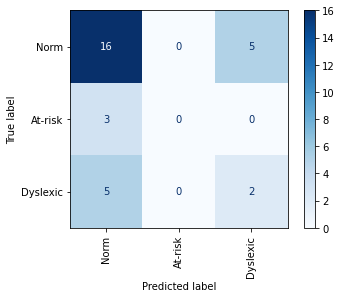

In [54]:


disp = sklearn.metrics.plot_confusion_matrix(
    mdl, x_test, y_test, 
    display_labels=class_names, 
    cmap=plt.cm.Blues, 
    xticks_rotation='vertical'
)




In [55]:

sklearn.metrics.roc_auc_score(y_test, 
                              mdl.predict_proba(x_test),
                              multi_class="ovr",
                              average="weighted"
                             )




0.5254224270353303

In [56]:

y_pred = mdl.predict(x_test)


In [57]:


sklearn.metrics.adjusted_rand_score(y_test, y_pred)


-0.047035276457343005

In [58]:

sklearn.metrics.normalized_mutual_info_score(y_test, y_pred)


0.04007039222448477

In [59]:


sklearn.metrics.precision_score(y_test, 
                                y_pred, 
                                average='weighted')



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.5161290322580645

In [60]:


sklearn.metrics.recall_score(y_test, y_pred, average='weighted')



0.5806451612903226

In [61]:

sklearn.metrics.f1_score(y_test, y_pred, average='weighted')



0.546236559139785

In [62]:

sklearn.metrics.accuracy_score(y_test, y_pred)


0.5806451612903226

In [63]:


sklearn.metrics.cohen_kappa_score(y_test, y_pred)



0.012254901960784381

- 




In [ ]:


len(list(x_org.columns)) == x_test.shape[1]




In [ ]:
explainer = shap.Explainer(mdl.predict, x_test, feature_names=list(x_org.columns))



In [ ]:


# shap_values = explainer(x_test)




In [ ]:


print("Shap values are determined!")



In [ ]:


y_test.shape, x_test.shape, shap_values.values.shape



- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- 

In [ ]:
# shap.summary_plot(shap_values, 
#                   x_test, 
#                   plot_type="bar", 
#                   class_names=class_names, 
#                   feature_names=list(x_org.columns),
#                   alpha=0.1,
#                   color_bar=True,
#                   color_bar_label=True
#                  )



### Shap bar plot



In [ ]:

shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")




- The bar plot above depicgts the Mean Absolute SHAP (MAS) values for each feature across the entire data. MAS, on average, quantifies, the magnitude of each feature's contribution towards the predicted class labels. The higher the MAS value for a a feature the more influential that feature is.


- The gender SHAP values sums up to 0.35 turning it two one of the most influentioal features. 
- IQ, Age and the third and fourth grades are the other important features in predicing the class labels.
- Althoght the remaining features have less significant SHAP values, still they all plan a role in predicting class labels.

- More info on beeswarm-bar plot 

In [ ]:
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}

for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = x_org.columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(x_org.columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()


# plt.savefig("plots/bar_beeswarm.png")



##### Beeswarm-bar plot: 

In addition to observe the same pattern on the relative importannce of features, one can observe that:

- There are quite a few sixth grade participants with very high SHAP values despite of its low MAS value in general.

- 



### SHAP Beeswarm Plots


- Permutation importance numerically measures the importance of features. This simplifies the comparison between features.  However, the considered interaction between features during the features importance determination process, as can be considered a severe drawback of this method. SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 

- The points are distributed horizontally along the x-axis according to their SHAP value. In places where there is a high density of SHAP values, the points are stacked vertically. Examining how the SHAP values are distributed reveals how a variable may influence the model's predictions.

- The colour bar corresponds to the raw values (not to be confused with the SHAP values) of the variables for each instance (i.e. point) on the graph. If the value of a variable for a particular instance is relatively high, it appears as a red dot. Relatively low variable values appear as blue dots. Examining the color distribution horizontally along the x-axis for each variable provides insights into the general relationship between a variable's raw values and its SHAP values.


- These (the columns) are the input variables, ranked from top to bottom by their mean absolute SHAP values for the entire dataset. Note: this ranking is exactly the same as for the bar plot.



In [ ]:
shap.summary_plot(shap_values=shap_values.values, 
                  features=x_test,
                  class_names=["Norm", "at-risk", "Dyslexic"],
                  feature_names=list(x_org.columns), 
                 )




- None-female (male) students have the highest negative SHAP values, implying the significance of this feature on prediction results. 


- Only the two extremes of students' "IQ" have direct impacts models prediction.


- Similar to IQ features, only the two extremes of "Age" feature plays an important role in models prediction.


- Most of the 3rd and 4th grade students, unlike the rest of grades, have high SHAP values which demostrates the importance of these two features.


- Fixation along Y-axis is more important than X-axis. 


- The 6th grade has no low impact on model's prediction result. 





### SHAP Dependence Contribution Plots

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.


- Each dot is a single prediction (row) from the dataset.
- The x-axis is the actual value from the dataset.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.

In [ ]:
n = 5
fig, ax = plt.subplots(1, n, figsize=(15, 5))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
# fig.savefig("plots/scatter_top5.png")


- The vertical spread of SHAP values at a fixed raw variable value is due to interaction effects with other variables. For example, here we see that sex_1 equal to unity (female) can have SHAP values that range from $-0.6 to 0.15$ depending on the other data for those particular instances. 


- The shapes of the distributions of points provide insights into the relationship between a variable's values and its SHAP values. We cannot see any specific relation between any individual feature and its importance (its SHAP values).



In [ ]:
# n = 5
# fig, ax = plt.subplots(1, n, figsize=(15, 5))

# for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
#     if i < n:
#         shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
#         ax[i].grid(axis="y")
#         if i != 0:
#             ax[i].set_ylabel("")
#             ax[i].spines["left"].set_visible(False)
#             ax[i].set_ylim(ax[0].get_ylim())
#             ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
#         else:
#             ax[i].set_ylabel("SHAP value")
# # fig.savefig("plots/scatter_top5.png")

##### Dependece plots:

- 


In [ ]:
for i in range(x_test.shape[1]):
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)



- 


## Individual force plots of 3 randomly selected samples of each class


In [ ]:



normals = np.where(y_test == 1)[0]
at_risks = np.where(y_test == 2)[0]
dyslexics = np.where(y_test == 3)[0]



n_size = 5
np.random.seed(43)
normals_rnd = np.random.choice(normals, n_size)
at_risks_rnd = np.random.choice(at_risks, n_size)
dyslexics_rnd = np.random.choice(dyslexics, n_size)




In [ ]:
normals_rnd



In [ ]:
at_risks_rnd


In [ ]:

dyslexics_rnd


In [ ]:
for n in normals_rnd:
    shap.plots.force(shap_values[n], show=False, matplotlib=True)
    
    

In [ ]:
for r in at_risks_rnd:
    shap.plots.force(shap_values[r], show=False, matplotlib=True)
    
    

In [ ]:
for d in dyslexics_rnd:
    shap.plots.force(shap_values[d], show=False, matplotlib=True)
    
    